In [1]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np



# GET DATA

In [2]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = today
# end_date = '2022-03-10'
#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
data_close = panel_data["Close"]
data_close.head(5).round(2)
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close


,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1931.946777,3530.0,1837.5,1845.677368
2010-01-05,1931.946777,3550.0,1875.0,1865.630737
2010-01-06,1931.946777,3530.0,1862.5,1875.607300
2010-01-07,1973.945557,3420.0,1875.0,1865.630737
2010-01-08,1973.945557,3440.0,1887.5,1855.654053
...,...,...,...,...
2022-09-13,2070.000000,7200.0,8525.0,3430.000000
2022-09-14,2120.000000,7150.0,8525.0,3570.000000
2022-09-15,2070.000000,7050.0,8600.0,3550.000000


In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [4]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [5]:
def decompose(df):
    #To separate the trend and the seasonality from a time series, 
    # we can decompose the series using the following code.
    result = seasonal_decompose(df, model='multiplicative', period = 30)
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(16, 9)

<AxesSubplot:ylabel='Density'>

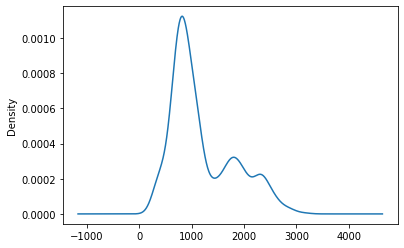

In [6]:
df_antm = data_close['antm']
#Distribution of the dataset
df_antm.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

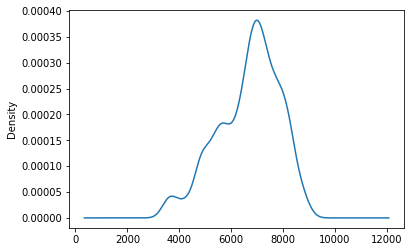

In [7]:
df_asii = data_close['asii']
#Distribution of the dataset
df_asii.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

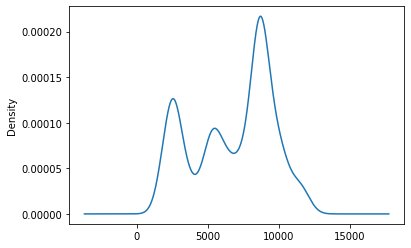

In [8]:
df_icbp = data_close['icbp']
#Distribution of the dataset
df_icbp.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

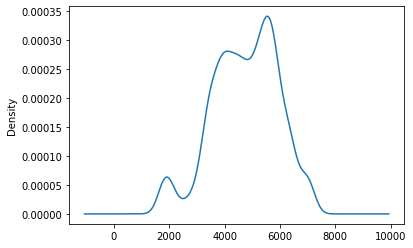

In [9]:
df_jsmr = data_close['jsmr']
#Distribution of the dataset
df_jsmr.plot(kind='kde')

# Test stationarity

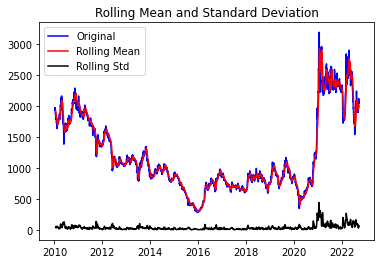

Results of dickey fuller test
Test Statistics                  -1.846846
p-value                           0.357464
No. of lags used                 21.000000
Number of observations used    3128.000000
critical value (1%)              -3.432442
critical value (5%)              -2.862464
critical value (10%)             -2.567262
dtype: float64


In [10]:
test_stationarity(df_antm)

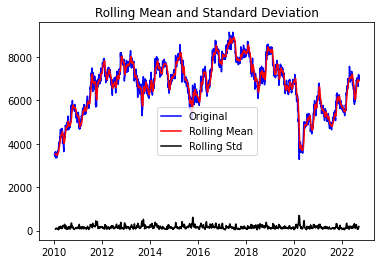

Results of dickey fuller test
Test Statistics                  -3.280093
p-value                           0.015792
No. of lags used                  6.000000
Number of observations used    3143.000000
critical value (1%)              -3.432432
critical value (5%)              -2.862460
critical value (10%)             -2.567260
dtype: float64


In [11]:
test_stationarity(df_asii)

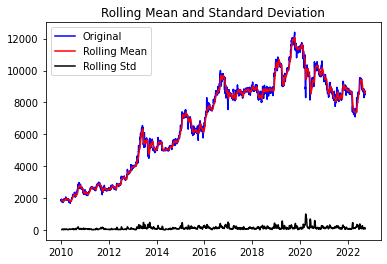

Results of dickey fuller test
Test Statistics                  -1.629353
p-value                           0.467830
No. of lags used                 13.000000
Number of observations used    3136.000000
critical value (1%)              -3.432437
critical value (5%)              -2.862462
critical value (10%)             -2.567261
dtype: float64


In [12]:
test_stationarity(df_icbp)

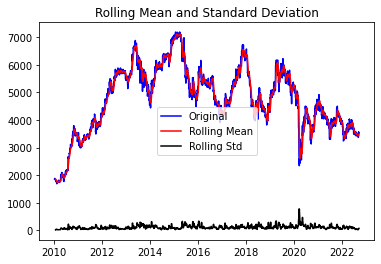

Results of dickey fuller test
Test Statistics                  -2.649181
p-value                           0.083253
No. of lags used                  3.000000
Number of observations used    3146.000000
critical value (1%)              -3.432430
critical value (5%)              -2.862459
critical value (10%)             -2.567259
dtype: float64


In [13]:
test_stationarity(df_jsmr)

# seasonal decompose

<Figure size 432x288 with 0 Axes>

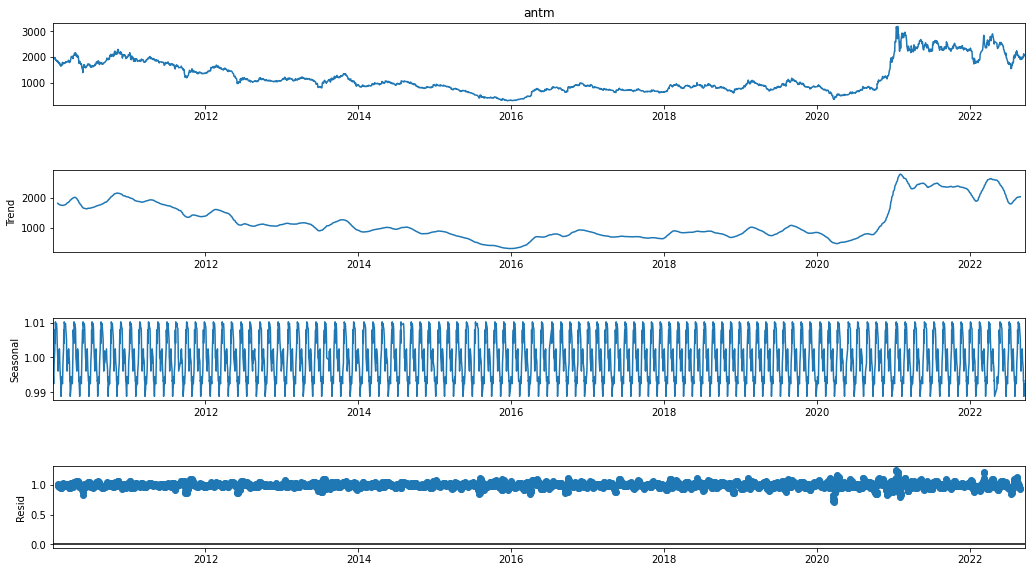

In [14]:
decompose(df_antm)

<Figure size 432x288 with 0 Axes>

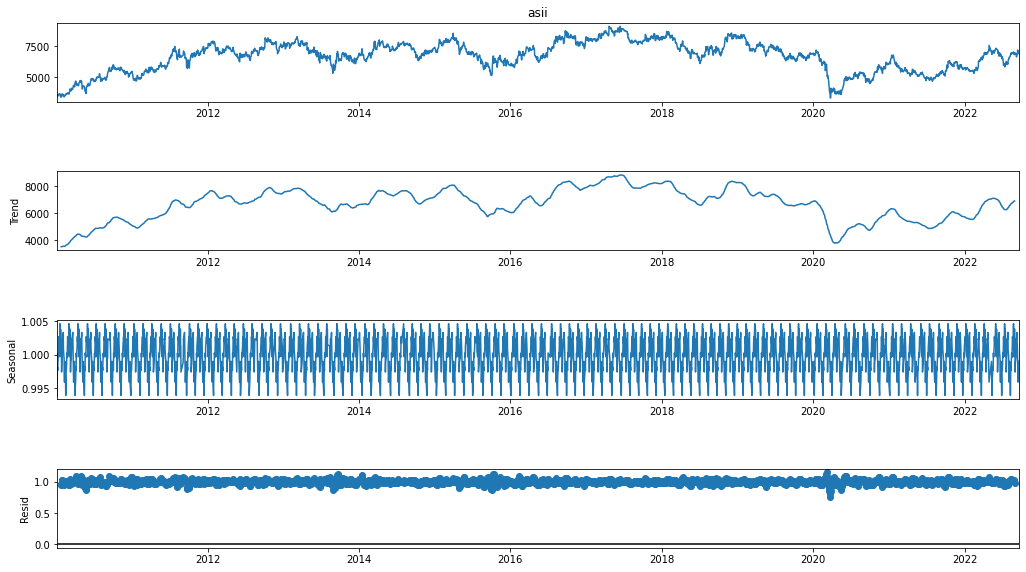

In [15]:
decompose(df_asii)

<Figure size 432x288 with 0 Axes>

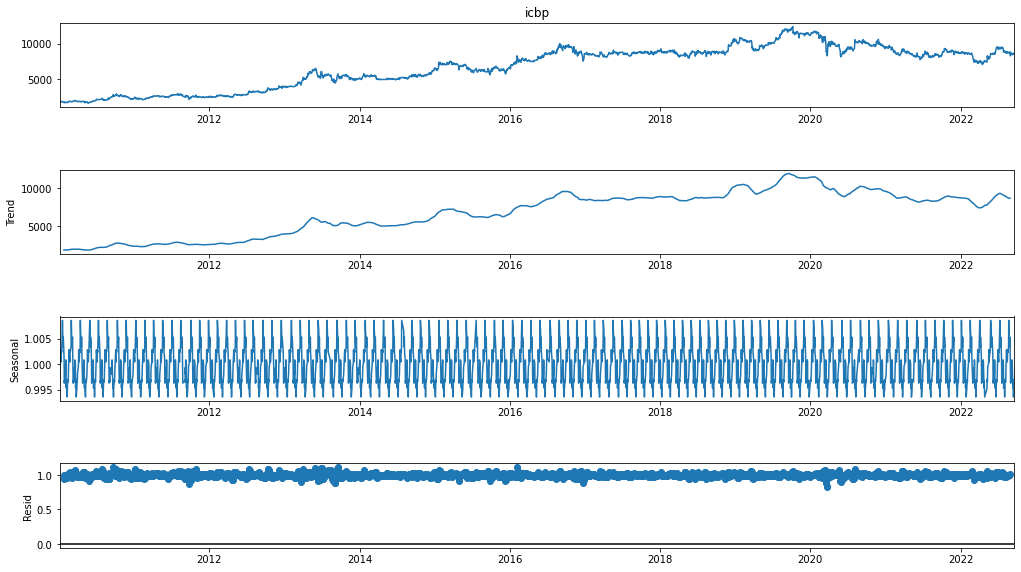

In [16]:
decompose(df_icbp)

<Figure size 432x288 with 0 Axes>

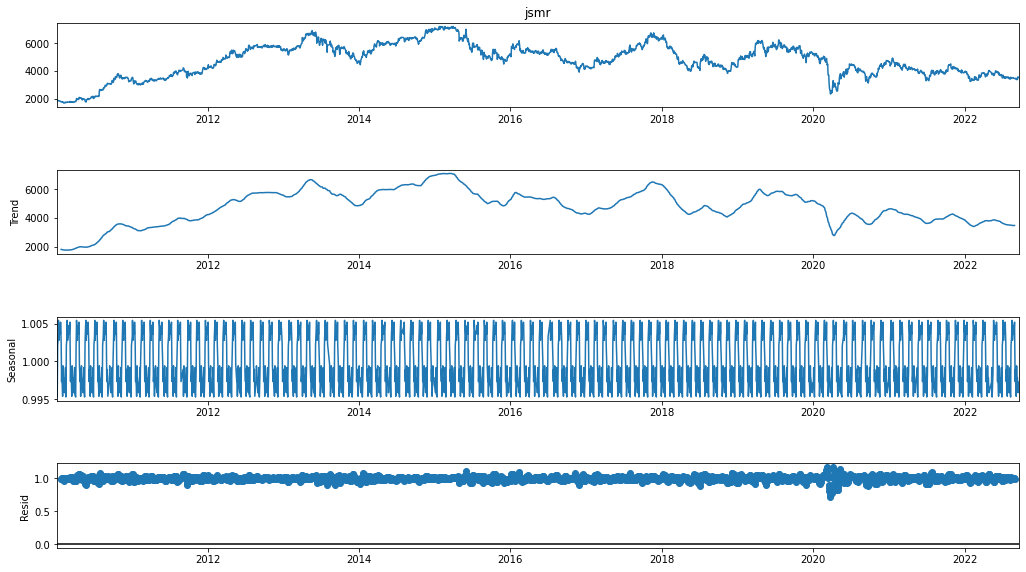

In [17]:
decompose(df_jsmr)

# Eliminate Trend

In [18]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
def eleminate_trend(df):
    rcParams['figure.figsize'] = 10, 6
    df_log = np.log(df)
    moving_avg = df_log.rolling(12).mean()
    std_dev = df_log.rolling(12).std()
    plt.legend(loc='best')
    plt.title('Moving Average')
    plt.plot(std_dev, color ="black", label = "Standard Deviation")
    plt.plot(moving_avg, color="red", label = "Mean")
    plt.legend()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


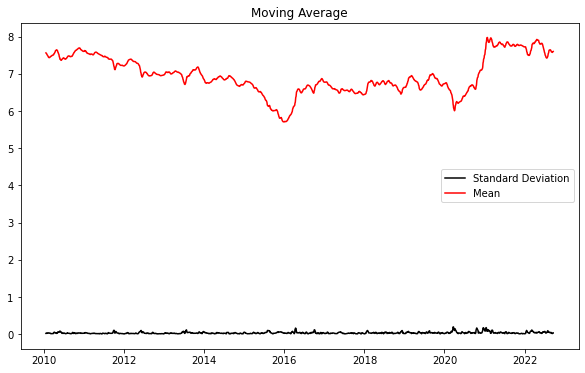

In [19]:
eleminate_trend(df_antm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


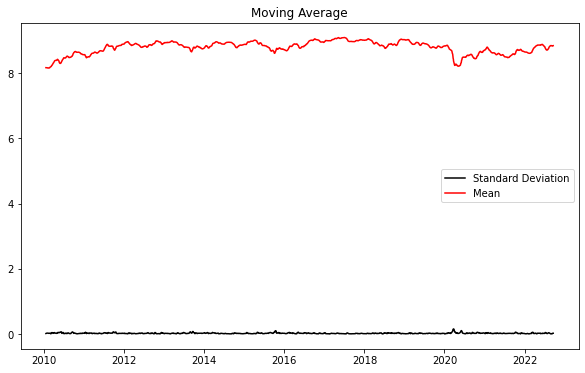

In [20]:
eleminate_trend(df_asii)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


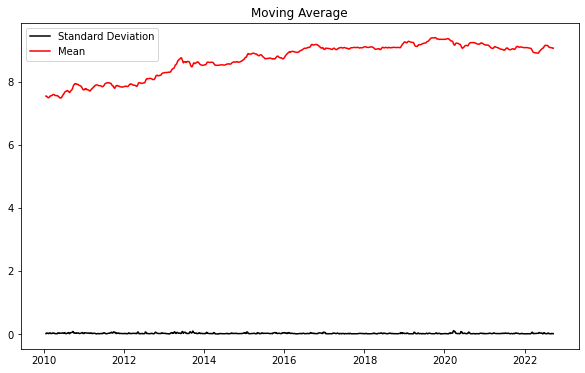

In [21]:
eleminate_trend(df_icbp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


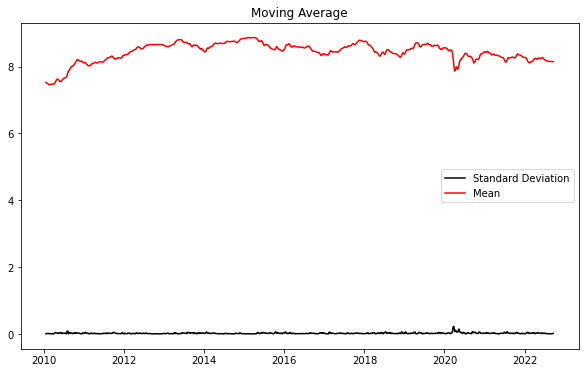

In [22]:
eleminate_trend(df_jsmr)

# Split Data

In [23]:
def plot_split_data(df, test_data):
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df, 'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()

In [24]:
def split_data(df):
    train_data = df[3:int(len(df)*0.33)]
    test_data =  df[int(len(df)*0.67):]
    plot_split_data(df,test_data)
    return train_data, test_data

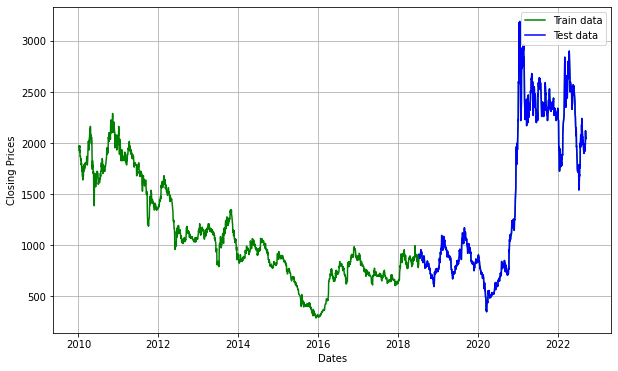

In [25]:
train_data_antm, test_data_antm = split_data(df_antm)

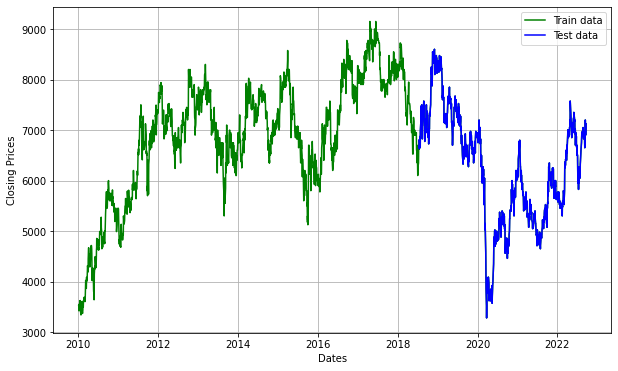

In [26]:
train_data_asii, test_data_asii = split_data(df_asii)

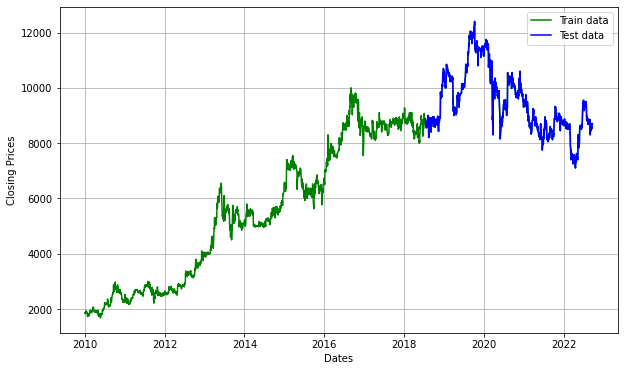

In [27]:
train_data_icbp, test_data_icbp = split_data(df_icbp)

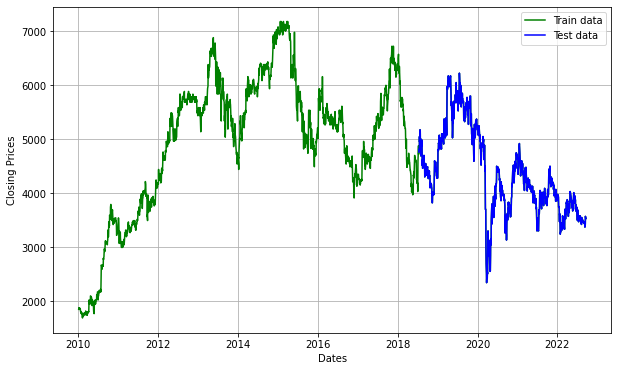

In [28]:
train_data_jsmr, test_data_jsmr = split_data(df_jsmr)

# AUTO ARIMA

In [29]:
def model_auto_arima(train_data):
    model_auto_arima = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(model_auto_arima.summary())
    model_auto_arima.plot_diagnostics(figsize=(15,8))
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10164.718, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10165.659, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10165.657, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10163.640, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10165.929, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.583 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1036
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5080.820
Date:                Mon, 19 Sep 2022   AIC                          10163.640
Time:                        19:32:07   BIC                          10168.582
Sample:                             0   HQIC                         10165.515
                               - 1036                                  

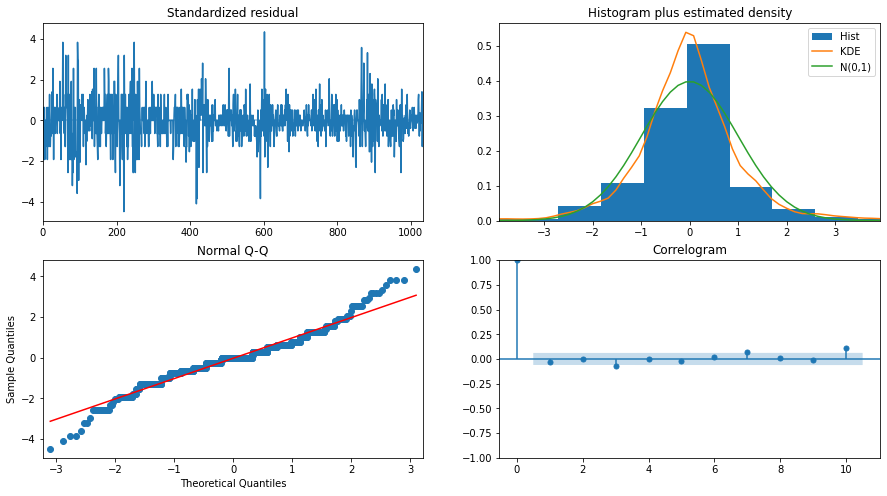

In [30]:
model_auto_arima(train_data_antm)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13121.638, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13123.482, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13123.470, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13120.396, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13112.940, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13113.060, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13113.288, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13123.814, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13124.282, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13114.472, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13112.995, Time=0.21 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.333 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

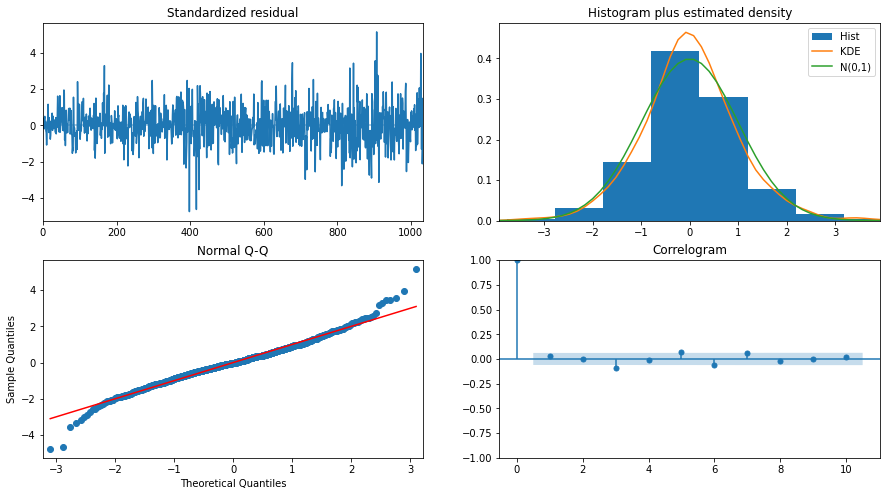

In [31]:
model_auto_arima(train_data_asii)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12124.109, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12125.568, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12125.578, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12123.431, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12127.574, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1036
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6060.716
Date:                Mon, 19 Sep 2022   AIC                          12123.431
Time:                        19:32:12   BIC                          12128.373
Sample:                             0   HQIC                         12125.306
                               - 1036                                  

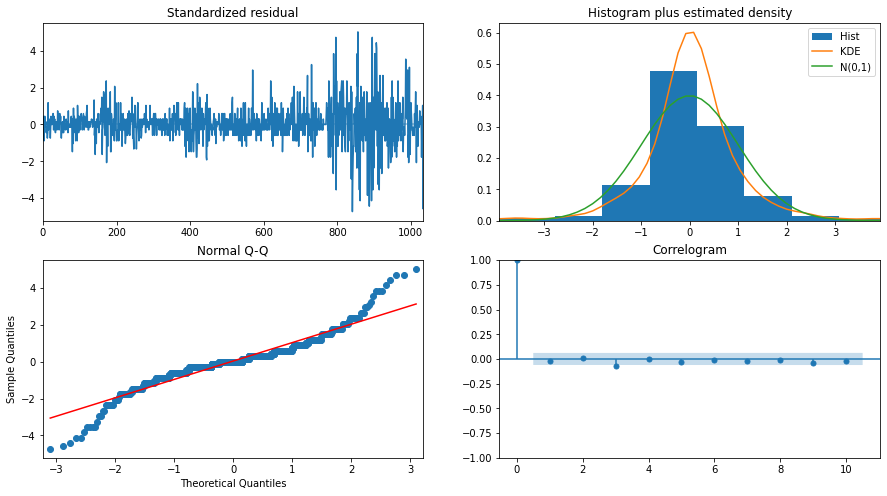

In [32]:
model_auto_arima(train_data_icbp)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12149.894, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12150.902, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12150.764, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12149.846, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12137.893, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12135.917, Time=0.65 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12149.413, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12134.532, Time=0.57 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12139.559, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12139.515, Time=1.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12134.655, Time=0.84 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=12136.564, Time=0.29 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 4.316 seconds
                               SARIMAX Results                              

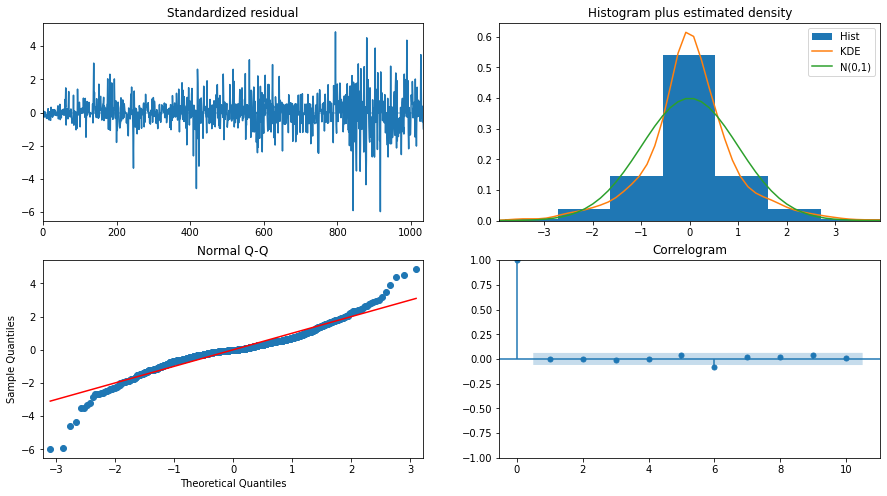

In [33]:
model_auto_arima(train_data_jsmr)

# MOdeling

## ANTM

In [34]:
#Modeling
# Build Model
model_ARIMA_antm = ARIMA(train_data_antm, order=(0,1,0))  
fitted_antm = model_ARIMA_antm.fit()  
print(fitted_antm.summary())

                               SARIMAX Results                                
Dep. Variable:                   antm   No. Observations:                 1036
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5080.820
Date:                Mon, 19 Sep 2022   AIC                          10163.640
Time:                        19:32:18   BIC                          10168.582
Sample:                             0   HQIC                         10165.515
                               - 1036                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1075.0621     31.439     34.196      0.000    1013.444    1136.680
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):               280.68
Prob(Q):                              0.30   Pr

c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


## ASII

In [35]:
#Modeling
# Build Model
model_ARIMA_asii = ARIMA(train_data_asii, order=(1,1,1))  
fitted_asii = model_ARIMA_asii.fit()  
print(fitted_asii.summary())

c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\App

                               SARIMAX Results                                
Dep. Variable:                   asii   No. Observations:                 1036
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6553.498
Date:                Mon, 19 Sep 2022   AIC                          13112.995
Time:                        19:32:18   BIC                          13127.822
Sample:                             0   HQIC                         13118.621
                               - 1036                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8499      0.063     13.512      0.000       0.727       0.973
ma.L1         -0.9054      0.052    -17.568      0.000      -1.006      -0.804
sigma2       1.85e+04    567.427     32.610      0.0

## ICBP

In [36]:
#Modeling
# Build Model
model_ARIMA_icbp = ARIMA(train_data_icbp, order=(0,1,0))  
fitted_icbp = model_ARIMA_icbp.fit()  
print(fitted_icbp.summary())

                               SARIMAX Results                                
Dep. Variable:                   icbp   No. Observations:                 1036
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6060.716
Date:                Mon, 19 Sep 2022   AIC                          12123.431
Time:                        19:32:18   BIC                          12128.373
Sample:                             0   HQIC                         12125.306
                               - 1036                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7141.3056    167.913     42.530      0.000    6812.201    7470.410
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):              1076.66
Prob(Q):                              0.46   Pr

c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


## JSMR

In [37]:
#Modeling
# Build Model
model_ARIMA_jsmr = ARIMA(train_data_jsmr, order=(3,1,1))  
fitted_jsmr = model_ARIMA_jsmr.fit()  
print(fitted_jsmr.summary())

c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                   jsmr   No. Observations:                 1036
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -6063.282
Date:                Mon, 19 Sep 2022   AIC                          12136.564
Time:                        19:32:18   BIC                          12161.275
Sample:                             0   HQIC                         12145.940
                               - 1036                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5483      0.127      4.301      0.000       0.298       0.798
ar.L2         -0.0411      0.028     -1.448      0.148      -0.097       0.015
ar.L3         -0.0709      0.031     -2.254      0.0

# FORECAST

In [56]:
def forecasting_antm(df):
    fc_df = fitted_antm.forecast(len(df), alpha=0.05)  # 95% conf
    return fc_df

In [57]:
def forecasting_asii(df):
    fc_df = fitted_asii.forecast(len(df), alpha=0.05)  # 95% conf
    return fc_df

In [58]:
def forecasting_icbp(df):
    fc_df = fitted_icbp.forecast(len(df), alpha=0.05)  # 95% conf
    return fc_df

In [59]:
def forecasting_jsmr(df):
    fc_df = fitted_jsmr.forecast(len(df), alpha=0.05)  # 95% conf
    return fc_df

In [60]:
fc_antm = forecasting_antm(test_data_antm)
fc_asii = forecasting_asii(test_data_asii)
fc_jsmr = forecasting_jsmr(test_data_jsmr)
fc_icbp = forecasting_icbp(test_data_icbp)

c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
c:\Users\MuhammadNurAlim\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model

# MEtric Evaluation

In [61]:
from sklearn.metrics import mean_absolute_percentage_error
def metric_eval(test_data, fc, lb_saham):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(fc, test_data)))
    print("mape score "+str(mean_absolute_percentage_error(fc, test_data)))
    print("rmse score "+str(np.sqrt(mean_squared_error(fc, test_data))))

In [67]:
metric_eval(fc_antm,test_data_antm ,'antm')

Matriks score for antm
mae score: 669.9553010206956
mape score 0.4020274318843281
rmse score 907.6144785953127


In [63]:
metric_eval(test_data_asii,fc_asii, 'asii')

Matriks score for asii
mae score: 1202.223646738977
mape score 0.16559605551819098
rmse score 1499.7193687942463


In [64]:
metric_eval(test_data_icbp,fc_icbp, 'icbp')

Matriks score for icbp
mae score: 4488.774038461538
mape score 0.8977548076923076
rmse score 4625.708950341475


In [65]:
metric_eval(test_data_jsmr,fc_jsmr, 'jsmr')

Matriks score for jsmr
mae score: 1389.102618102191
mape score 0.24206759677096912
rmse score 1576.3808451019647
